In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
!nvidia-smi

Fri Oct 11 05:16:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      5MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [4]:
def build_resnet(
    input_shape=(224,224,3),
    num_cnn_list=[3,4,6,3],
    channel_list=[64,128,256,512],
    num_classes=2, 
    is_50 = False, 
    is_plain = False
):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 2
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model
 

In [24]:
resnet34_model = build_resnet(is_50 = False)

In [25]:
resnet34_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 112, 112, 64) 832         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 112, 112, 64) 256         conv2d_16[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_68[0][0]     
____________________________________________________________________________________________

In [26]:
resnet50_model = build_resnet(is_50 = True)

In [27]:
resnet50_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 112, 112, 64) 832         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 112, 112, 64) 256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_85[0][0]     
____________________________________________________________________________________________

In [28]:
plain34_model = build_resnet(is_50 = False, is_plain = True)
plain50_model = build_resnet(is_50 = True, is_plain = True)

In [29]:
plain34_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 112, 112, 64) 832         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_102 (BatchN (None, 112, 112, 64) 256         conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_102[0][0]    
____________________________________________________________________________________________

In [30]:
plain50_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 112, 112, 64) 832         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_119 (BatchN (None, 112, 112, 64) 256         conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_119[0][0]    
____________________________________________________________________________________________

In [31]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

datasets, info = tfds.load('cats_vs_dogs', 
                     split=['train[:80%]', 'train[80%:]'], 
                     with_info=True, 
                     as_supervised=True)

In [40]:
train_dataset, test_dataset = datasets

In [41]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [224,224])  # 이미지 크기 조정
    image = image / 255.0  # 정규화
    return image, label

In [42]:
# 전처리 적용
train_dataset = train_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

In [43]:
# 이미지와 라벨 구분
for images, labels in train_dataset.take(1):  # 첫 배치 가져오기
    # 이미지와 라벨 확인
    print("Images shape:", images.shape)  # 이미지 텐서의 shape
    print("Labels shape:", labels.shape)  # 라벨 텐서의 shape

Images shape: (32, 224, 224, 3)
Labels shape: (32,)


In [44]:
## 모델 complie
resnet34_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
        lr=0.001, 
#         clipnorm=1.
    ),
    metrics=['accuracy'],
)
plain34_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
        lr=0.001, 
#         clipnorm=1.
    ),
    metrics=['accuracy'],
)
resnet50_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
        lr=0.001, 
#         clipnorm=1.
    ),
    metrics=['accuracy'],
)
plain50_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
        lr=0.001, 
#         clipnorm=1.
    ),
    metrics=['accuracy'],
)

In [45]:
EPOCH = 30

In [49]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_loss', 
    patience = 2, 
#     mode = 'auto'
)


In [50]:
history_resnet34 = resnet34_model.fit(
    train_dataset,
#     steps_per_epoch=int(train_dataset.splits['train'].num_examples/BATCH_SIZE),
#     validation_steps=int(train_dataset.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test_dataset,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[early_stopping]
)

Epoch 1/30
195/582 [=========>....................] - ETA: 53s - loss: 0.6932 - accuracy: 0.5043

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 49s - loss: 0.6932 - accuracy: 0.5052

237/582 [===========>..................] - ETA: 47s - loss: 0.6931 - accuracy: 0.5058

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 37s - loss: 0.6932 - accuracy: 0.5011

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.6932 - accuracy: 0.5010

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.6932 - accuracy: 0.5017

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 5s - loss: 0.6932 - accuracy: 0.5016

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 1s - loss: 0.6932 - accuracy: 0.5025

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6932 - accuracy: 0.5025

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5019

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 88s 151ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 27610716.0000 - val_accuracy: 0.4899
Epoch 2/30
195/582 [=========>....................] - ETA: 54s - loss: 0.6932 - accuracy: 0.5043

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5052

237/582 [===========>..................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5058

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 38s - loss: 0.6932 - accuracy: 0.5011

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.6932 - accuracy: 0.5012

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.6932 - accuracy: 0.5019

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 5s - loss: 0.6932 - accuracy: 0.5018

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 1s - loss: 0.6932 - accuracy: 0.5027

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6932 - accuracy: 0.5027

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5021

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 89s 153ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 27610304.0000 - val_accuracy: 0.4899
Epoch 3/30
195/582 [=========>....................] - ETA: 54s - loss: 0.6932 - accuracy: 0.5043

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5052

237/582 [===========>..................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5058

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 38s - loss: 0.6932 - accuracy: 0.5011

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.6932 - accuracy: 0.5012

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.6932 - accuracy: 0.5019

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 5s - loss: 0.6932 - accuracy: 0.5018

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 1s - loss: 0.6932 - accuracy: 0.5027

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6932 - accuracy: 0.5027

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5021

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 89s 153ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 27610204.0000 - val_accuracy: 0.4899
Epoch 4/30
195/582 [=========>....................] - ETA: 54s - loss: 0.6932 - accuracy: 0.5043

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5052

237/582 [===========>..................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5058

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 38s - loss: 0.6932 - accuracy: 0.5023

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.6932 - accuracy: 0.5019

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.6932 - accuracy: 0.5027

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 5s - loss: 0.6932 - accuracy: 0.5025

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 1s - loss: 0.6932 - accuracy: 0.5034

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6932 - accuracy: 0.5034

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5027

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 89s 153ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 27610204.0000 - val_accuracy: 0.4899
Epoch 5/30
195/582 [=========>....................] - ETA: 53s - loss: 0.6932 - accuracy: 0.5043

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 48s - loss: 0.6932 - accuracy: 0.5052

237/582 [===========>..................] - ETA: 47s - loss: 0.6931 - accuracy: 0.5058

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 37s - loss: 0.6932 - accuracy: 0.5023

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.6932 - accuracy: 0.5019

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.6932 - accuracy: 0.5027

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 5s - loss: 0.6932 - accuracy: 0.5025

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 1s - loss: 0.6932 - accuracy: 0.5034

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6932 - accuracy: 0.5034

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5027

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 87s 150ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 27610204.0000 - val_accuracy: 0.4899


In [51]:
history_plain34 = plain34_model.fit(
    train_dataset,
#     steps_per_epoch=int(train_dataset.splits['train'].num_examples/BATCH_SIZE),
#     validation_steps=int(train_dataset.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test_dataset,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[early_stopping]
)

Epoch 1/30
195/582 [=========>....................] - ETA: 56s - loss: 0.1853 - accuracy: 0.9277

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 51s - loss: 0.1828 - accuracy: 0.9284

237/582 [===========>..................] - ETA: 50s - loss: 0.1814 - accuracy: 0.9292

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 39s - loss: 0.1811 - accuracy: 0.9266

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.1775 - accuracy: 0.9286

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.1768 - accuracy: 0.9286

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.1755 - accuracy: 0.9291

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.1750 - accuracy: 0.9295

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.1753 - accuracy: 0.9293

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9293

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 96s 165ms/step - loss: 0.1755 - accuracy: 0.9293 - val_loss: 0.2375 - val_accuracy: 0.8975
Epoch 2/30
195/582 [=========>....................] - ETA: 56s - loss: 0.1537 - accuracy: 0.9369

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 52s - loss: 0.1468 - accuracy: 0.9404

237/582 [===========>..................] - ETA: 50s - loss: 0.1449 - accuracy: 0.9416

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 40s - loss: 0.1423 - accuracy: 0.9433

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.1443 - accuracy: 0.9421

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.1447 - accuracy: 0.9422

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.1451 - accuracy: 0.9421

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.1444 - accuracy: 0.9422

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.1443 - accuracy: 0.9422

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1444 - accuracy: 0.9423

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 93s 159ms/step - loss: 0.1444 - accuracy: 0.9423 - val_loss: 738.9696 - val_accuracy: 0.7915
Epoch 3/30
195/582 [=========>....................] - ETA: 55s - loss: 0.1272 - accuracy: 0.9470

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 50s - loss: 0.1253 - accuracy: 0.9484

237/582 [===========>..................] - ETA: 49s - loss: 0.1245 - accuracy: 0.9484

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 39s - loss: 0.1260 - accuracy: 0.9482

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.1210 - accuracy: 0.9513

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.1213 - accuracy: 0.9516

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 5s - loss: 0.1209 - accuracy: 0.9516

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.1215 - accuracy: 0.9513

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.1213 - accuracy: 0.9514

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9516

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 90s 155ms/step - loss: 0.1209 - accuracy: 0.9516 - val_loss: 0.2644 - val_accuracy: 0.8996


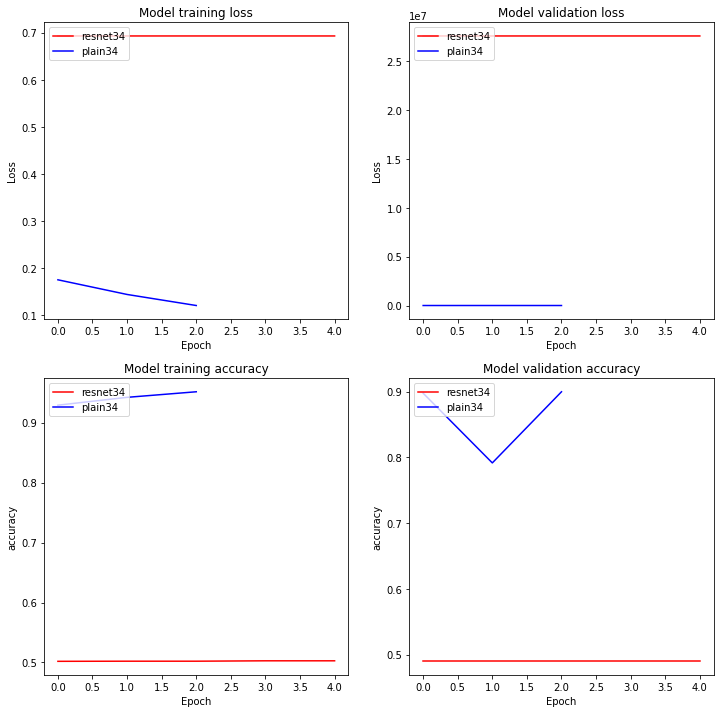

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(history_resnet34.history['loss'], 'r')
plt.plot(history_plain34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain34'], loc='upper left')

plt.subplot(2,2,2)
plt.plot(history_resnet34.history['val_loss'], 'r')
plt.plot(history_plain34.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain34'], loc='upper left')

plt.subplot(2,2,3)
plt.plot(history_resnet34.history['accuracy'], 'r')
plt.plot(history_plain34.history['accuracy'], 'b')
plt.title('Model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain34'], loc='upper left')

plt.subplot(2,2,4)
plt.plot(history_resnet34.history['val_accuracy'], 'r')
plt.plot(history_plain34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain34'], loc='upper left')

plt.show()

In [54]:
history_resnet50 = resnet50_model.fit(
    train_dataset,
#     steps_per_epoch=int(train_dataset.splits['train'].num_examples/BATCH_SIZE),
#     validation_steps=int(train_dataset.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test_dataset,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[early_stopping]
)

Epoch 1/30
195/582 [=========>....................] - ETA: 53s - loss: 1.9742 - accuracy: 0.6128

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 48s - loss: 1.7785 - accuracy: 0.6218

237/582 [===========>..................] - ETA: 47s - loss: 1.7280 - accuracy: 0.6242

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 37s - loss: 1.4576 - accuracy: 0.6429

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 1.0867 - accuracy: 0.6787

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 1.0724 - accuracy: 0.6805

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 5s - loss: 1.0608 - accuracy: 0.6822

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 1s - loss: 1.0349 - accuracy: 0.6853

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 1.0302 - accuracy: 0.6853

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 1.0241 - accuracy: 0.6856

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 90s 151ms/step - loss: 1.0241 - accuracy: 0.6856 - val_loss: 0.5432 - val_accuracy: 0.7227
Epoch 2/30
195/582 [=========>....................] - ETA: 55s - loss: 0.4974 - accuracy: 0.7633

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 50s - loss: 0.4967 - accuracy: 0.7631

237/582 [===========>..................] - ETA: 49s - loss: 0.4965 - accuracy: 0.7629

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 39s - loss: 0.4879 - accuracy: 0.7677

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.4722 - accuracy: 0.7790

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.4718 - accuracy: 0.7791

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 5s - loss: 0.4705 - accuracy: 0.7797

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.4685 - accuracy: 0.7806

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.4691 - accuracy: 0.7802

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4691 - accuracy: 0.7803

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 90s 155ms/step - loss: 0.4691 - accuracy: 0.7803 - val_loss: 0.4465 - val_accuracy: 0.7885
Epoch 3/30
195/582 [=========>....................] - ETA: 56s - loss: 0.4184 - accuracy: 0.8131

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 51s - loss: 0.4156 - accuracy: 0.8139

237/582 [===========>..................] - ETA: 50s - loss: 0.4149 - accuracy: 0.8141

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 39s - loss: 0.4028 - accuracy: 0.8211

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.3820 - accuracy: 0.8298

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.3829 - accuracy: 0.8297

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.3827 - accuracy: 0.8299

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.3822 - accuracy: 0.8303

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.3824 - accuracy: 0.8300

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.8300

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 92s 158ms/step - loss: 0.3826 - accuracy: 0.8300 - val_loss: 0.3969 - val_accuracy: 0.8192
Epoch 4/30
195/582 [=========>....................] - ETA: 57s - loss: 0.3334 - accuracy: 0.8551

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 52s - loss: 0.3275 - accuracy: 0.8567

237/582 [===========>..................] - ETA: 50s - loss: 0.3273 - accuracy: 0.8577

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 40s - loss: 0.3183 - accuracy: 0.8614

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.3019 - accuracy: 0.8688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.3016 - accuracy: 0.8679

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.3012 - accuracy: 0.8686

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.3013 - accuracy: 0.8687

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.3023 - accuracy: 0.8677

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3029 - accuracy: 0.8674

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 93s 159ms/step - loss: 0.3029 - accuracy: 0.8674 - val_loss: 0.3208 - val_accuracy: 0.8512
Epoch 5/30
195/582 [=========>....................] - ETA: 57s - loss: 0.2868 - accuracy: 0.8835

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 52s - loss: 0.2805 - accuracy: 0.8856

237/582 [===========>..................] - ETA: 50s - loss: 0.2813 - accuracy: 0.8855

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 40s - loss: 0.2726 - accuracy: 0.8879

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.2544 - accuracy: 0.8939

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.2541 - accuracy: 0.8935

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.2532 - accuracy: 0.8936

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.2519 - accuracy: 0.8943

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.2524 - accuracy: 0.8939

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.8937

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 93s 159ms/step - loss: 0.2527 - accuracy: 0.8937 - val_loss: 0.3819 - val_accuracy: 0.7990
Epoch 6/30
195/582 [=========>....................] - ETA: 57s - loss: 0.2147 - accuracy: 0.9067

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 52s - loss: 0.2136 - accuracy: 0.9082

237/582 [===========>..................] - ETA: 51s - loss: 0.2136 - accuracy: 0.9081

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 40s - loss: 0.2137 - accuracy: 0.9077

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.2136 - accuracy: 0.9097

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.2140 - accuracy: 0.9093

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.2132 - accuracy: 0.9098

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.2122 - accuracy: 0.9104

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.2121 - accuracy: 0.9105

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9105

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 93s 159ms/step - loss: 0.2119 - accuracy: 0.9105 - val_loss: 118.0266 - val_accuracy: 0.8710


In [55]:
history_plain50 = plain50_model.fit(
    train_dataset,
#     steps_per_epoch=int(train_dataset.splits['train'].num_examples/BATCH_SIZE),
#     validation_steps=int(train_dataset.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test_dataset,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[early_stopping]
)

Epoch 1/30
195/582 [=========>....................] - ETA: 57s - loss: 2.0167 - accuracy: 0.5894

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 52s - loss: 1.8227 - accuracy: 0.5998

237/582 [===========>..................] - ETA: 51s - loss: 1.7736 - accuracy: 0.6010

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 40s - loss: 1.4997 - accuracy: 0.6219

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 1.1175 - accuracy: 0.6608

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 1.1032 - accuracy: 0.6626

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 1.0910 - accuracy: 0.6646

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 1.0643 - accuracy: 0.6678

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 1.0593 - accuracy: 0.6682

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 1.0528 - accuracy: 0.6686

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 96s 161ms/step - loss: 1.0528 - accuracy: 0.6686 - val_loss: 0.5473 - val_accuracy: 0.7160
Epoch 2/30
195/582 [=========>....................] - ETA: 55s - loss: 0.5060 - accuracy: 0.7535

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 50s - loss: 0.5003 - accuracy: 0.7580

237/582 [===========>..................] - ETA: 49s - loss: 0.4995 - accuracy: 0.7583

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 39s - loss: 0.4929 - accuracy: 0.7612

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.4742 - accuracy: 0.7742

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.4741 - accuracy: 0.7740

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 5s - loss: 0.4731 - accuracy: 0.7748

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.4704 - accuracy: 0.7768

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.4710 - accuracy: 0.7764

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.7761

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 91s 156ms/step - loss: 0.4711 - accuracy: 0.7761 - val_loss: 0.7750 - val_accuracy: 0.7577
Epoch 3/30
195/582 [=========>....................] - ETA: 54s - loss: 0.4017 - accuracy: 0.8163

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 50s - loss: 0.3998 - accuracy: 0.8175

237/582 [===========>..................] - ETA: 48s - loss: 0.3973 - accuracy: 0.8192

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 38s - loss: 0.3851 - accuracy: 0.8248

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.3622 - accuracy: 0.8377

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.3632 - accuracy: 0.8376

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 5s - loss: 0.3630 - accuracy: 0.8376

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.3612 - accuracy: 0.8387

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.3618 - accuracy: 0.8383

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8380

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 90s 155ms/step - loss: 0.3622 - accuracy: 0.8380 - val_loss: 0.3708 - val_accuracy: 0.8549
Epoch 4/30
195/582 [=========>....................] - ETA: 56s - loss: 0.2903 - accuracy: 0.8761

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 51s - loss: 0.2848 - accuracy: 0.8790

237/582 [===========>..................] - ETA: 50s - loss: 0.2853 - accuracy: 0.8794

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 39s - loss: 0.2791 - accuracy: 0.8825

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.2716 - accuracy: 0.8855

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.2720 - accuracy: 0.8858

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.2722 - accuracy: 0.8860

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.2702 - accuracy: 0.8870

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.2712 - accuracy: 0.8863

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.8857

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 92s 158ms/step - loss: 0.2725 - accuracy: 0.8857 - val_loss: 6854090.0000 - val_accuracy: 0.8375
Epoch 5/30
195/582 [=========>....................] - ETA: 57s - loss: 0.2422 - accuracy: 0.8992

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 52s - loss: 0.2359 - accuracy: 0.9028

237/582 [===========>..................] - ETA: 50s - loss: 0.2367 - accuracy: 0.9024

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 40s - loss: 0.2334 - accuracy: 0.9026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 9s - loss: 0.2224 - accuracy: 0.9081

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 7s - loss: 0.2237 - accuracy: 0.9073

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.2229 - accuracy: 0.9080

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.2211 - accuracy: 0.9086

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.2212 - accuracy: 0.9085

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9086

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 93s 160ms/step - loss: 0.2211 - accuracy: 0.9086 - val_loss: 0.9380 - val_accuracy: 0.8996


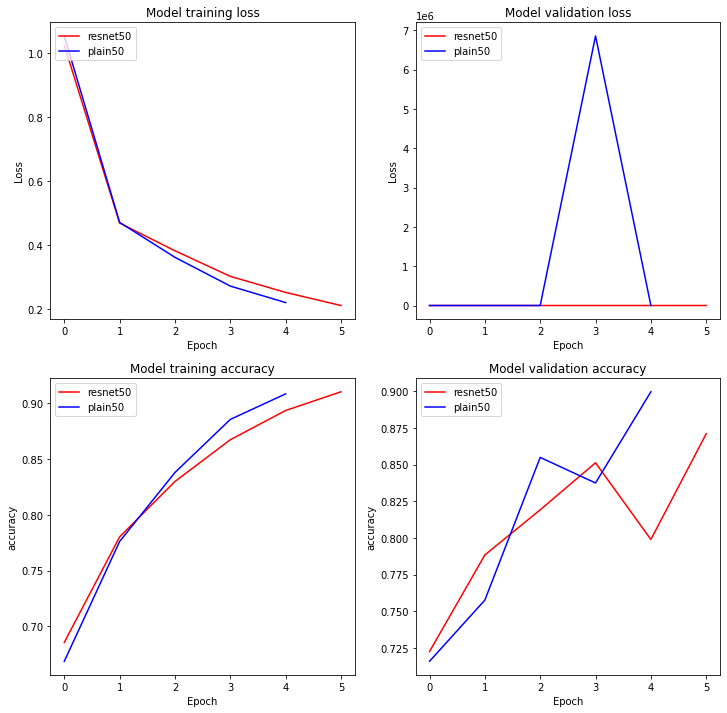

In [57]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_plain50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain50'], loc='upper left')

plt.subplot(2,2,2)
plt.plot(history_resnet50.history['val_loss'], 'r')
plt.plot(history_plain50.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain50'], loc='upper left')

plt.subplot(2,2,3)
plt.plot(history_resnet50.history['accuracy'], 'r')
plt.plot(history_plain50.history['accuracy'], 'b')
plt.title('Model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain50'], loc='upper left')

plt.subplot(2,2,4)
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_plain50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain50'], loc='upper left')

plt.show()

### 회고
스스로 resnet을 구현하려 했으나 완성하지 못했다. 
주말에 조금 더 작성해서 직접 구현한 모델을 완성하고 돌려야겠다.  